In [5561]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [5562]:
#!pip install tqdm

In [5563]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv')
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')

In [5564]:
#df0['action'] = df0['action'].replace('do_nothing', 'go_long')
#df0 = df0[df0['action'] != 'do_nothing']

In [5565]:
#df0 = df0.reset_index(drop=True)

In [5566]:
df0.head()

,Unnamed: 0,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward
0,0,12.4750,13.3580,12.509969,12.304971,12.4570,0,13.3560,493632.0,12.323680,0,0,12.59940,12.531571,0,1,do_nothing,go_short,do_nothing,2.765190
1,1,301.0800,306.6000,297.368301,293.048934,300.3800,0,305.8700,97836.0,291.372800,0,0,300.17800,299.475714,0,1,do_nothing,go_short,do_nothing,0.301170
2,2,626.6400,631.9500,618.904756,612.673035,625.6200,0,627.1800,26240.0,615.152000,0,0,623.06600,620.297143,0,0,go_long,go_short,do_nothing,-1.788648
3,3,0.3788,0.3846,0.371708,0.362725,0.3774,1,0.3812,24478.0,0.361024,0,0,0.37754,0.376686,0,1,do_nothing,go_short,do_nothing,0.303548
4,4,1.0155,1.0440,0.990258,0.971368,1.0134,0,1.0309,196121.0,0.977404,0,0,0.99874,0.992914,0,1,do_nothing,go_short,do_nothing,0.529565


In [5567]:
df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5568]:
df0['action'].value_counts()

action
go_long       512
do_nothing    425
Name: count, dtype: int64

In [5569]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [5570]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [5571]:
train_data = df0 #prep_data(df0)

In [5572]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-05,sma-07,sma-compare,is_short,action,imit-action,nlpreds,reward
0,12.475,13.358,12.509969,12.304971,12.457,0,13.356,493632.0,12.32368,0,0,12.5994,12.531571,0,1,do_nothing,go_short,do_nothing,2.76519
1,301.080,306.600,297.368301,293.048934,300.380,0,305.870,97836.0,291.37280,0,0,300.1780,299.475714,0,1,do_nothing,go_short,do_nothing,0.30117


In [5573]:
new_cols = ['open', 'high', 'ema-26', 'ema-12', 'low', \
            'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', \
            'sma-compare', 'is_short'
        ]

In [5574]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["nlpreds"].map(action_mapping)

In [5575]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [5576]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [5577]:
# Hyperparameters [0.25, 0.95, 1.0, 0.99, 0.99, 10000], [0.9, 0.95, 1.0, 0.99, 0.99, 8000], [0.7, 0.75, 1.0, 0.97, 0.999, 28000]
# [0.05, 0.95, 1.0, 0.999, 0.995, 12000], [1, 0.95, 0.1, 0.96, 0.96, 12000], [0.25, 0.99, 0.01, 0.997, 0.99, 8000]
# [1, 0.75, 0.05, 0.999, 0.999, 10000], [0.01, 0.85, 0.01, 0.95, 0.95, 12000], [0.01, 0.99, 1.0, 0.95, 0.99, 16000], [0.05, 0.99, 0.5, 0.99, 0.997, 6000]
# [0.25, 0.95, 0.01, 0.997, 0.999, 14000], [0.01, 0.95, 1.0, 0.997, 0.995, 26000], [0.001, 0.75, 1.0, 0.99, 0.99, 30000], [0.9, 0.9, 0.005, 0.95, 0.999, 10000]
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''
alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = 0.9, 0.9, 0.005, 0.95, 0.999, 10000 #0.9, 0.95, 1.0, 0.99, 0.99, 8000



In [5578]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('large_state_to_index.npy', state_to_index)


In [5579]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   1%|          | 75/10000 [00:00<00:26, 380.66it/s]

Episode 0/10000 - Total Reward: -177.20485005000003, Epsilon: 0.95


evaluating results per episode ...:   5%|▍         | 453/10000 [00:01<00:31, 306.01it/s]

Episode 400/10000 - Total Reward: -163.65522306, Epsilon: 0.95


evaluating results per episode ...:   9%|▊         | 858/10000 [00:02<00:26, 340.96it/s]

Episode 800/10000 - Total Reward: -107.28029829000009, Epsilon: 0.95


evaluating results per episode ...:  13%|█▎        | 1265/10000 [00:03<00:24, 359.67it/s]

Episode 1200/10000 - Total Reward: -12.234629519999999, Epsilon: 0.95


evaluating results per episode ...:  17%|█▋        | 1662/10000 [00:05<00:24, 337.24it/s]

Episode 1600/10000 - Total Reward: -111.57918979000009, Epsilon: 0.95


evaluating results per episode ...:  20%|██        | 2040/10000 [00:06<00:24, 323.37it/s]

Episode 2000/10000 - Total Reward: -157.14101836000006, Epsilon: 0.95


evaluating results per episode ...:  25%|██▍       | 2458/10000 [00:07<00:22, 340.03it/s]

Episode 2400/10000 - Total Reward: -163.65522306, Epsilon: 0.95


evaluating results per episode ...:  28%|██▊       | 2844/10000 [00:08<00:19, 370.43it/s]

Episode 2800/10000 - Total Reward: -103.00163926000006, Epsilon: 0.95


evaluating results per episode ...:  33%|███▎      | 3265/10000 [00:09<00:20, 332.25it/s]

Episode 3200/10000 - Total Reward: -158.51440208, Epsilon: 0.95


evaluating results per episode ...:  36%|███▋      | 3646/10000 [00:11<00:19, 322.27it/s]

Episode 3600/10000 - Total Reward: -121.96443910000006, Epsilon: 0.95


evaluating results per episode ...:  41%|████      | 4063/10000 [00:12<00:17, 341.04it/s]

Episode 4000/10000 - Total Reward: -102.19321662000009, Epsilon: 0.95


evaluating results per episode ...:  44%|████▍     | 4448/10000 [00:13<00:17, 312.00it/s]

Episode 4400/10000 - Total Reward: -44.12832929, Epsilon: 0.95


evaluating results per episode ...:  49%|████▊     | 4860/10000 [00:14<00:15, 340.12it/s]

Episode 4800/10000 - Total Reward: -92.80472562000007, Epsilon: 0.95


evaluating results per episode ...:  52%|█████▏    | 5233/10000 [00:15<00:14, 321.10it/s]

Episode 5200/10000 - Total Reward: -13.724931299999998, Epsilon: 0.95


evaluating results per episode ...:  57%|█████▋    | 5658/10000 [00:17<00:12, 335.77it/s]

Episode 5600/10000 - Total Reward: -81.74379843999999, Epsilon: 0.95


evaluating results per episode ...:  60%|██████    | 6039/10000 [00:18<00:11, 332.93it/s]

Episode 6000/10000 - Total Reward: -0.1557309999999999, Epsilon: 0.95


evaluating results per episode ...:  64%|██████▍   | 6439/10000 [00:19<00:12, 294.41it/s]

Episode 6400/10000 - Total Reward: -122.97971695000005, Epsilon: 0.95


evaluating results per episode ...:  69%|██████▊   | 6871/10000 [00:20<00:08, 348.47it/s]

Episode 6800/10000 - Total Reward: -52.81998725999997, Epsilon: 0.95


evaluating results per episode ...:  73%|███████▎  | 7277/10000 [00:22<00:09, 301.79it/s]

Episode 7200/10000 - Total Reward: -161.91095604, Epsilon: 0.95


evaluating results per episode ...:  76%|███████▋  | 7644/10000 [00:23<00:07, 294.93it/s]

Episode 7600/10000 - Total Reward: -104.5977644900001, Epsilon: 0.95


evaluating results per episode ...:  81%|████████  | 8074/10000 [00:24<00:05, 358.82it/s]

Episode 8000/10000 - Total Reward: -103.03520559000007, Epsilon: 0.95


evaluating results per episode ...:  84%|████████▍ | 8448/10000 [00:25<00:04, 315.39it/s]

Episode 8400/10000 - Total Reward: -12.518126209999995, Epsilon: 0.95


evaluating results per episode ...:  88%|████████▊ | 8846/10000 [00:26<00:03, 334.98it/s]

Episode 8800/10000 - Total Reward: -132.96300815999993, Epsilon: 0.95


evaluating results per episode ...:  92%|█████████▏| 9248/10000 [00:28<00:02, 345.98it/s]

Episode 9200/10000 - Total Reward: -124.60556944000005, Epsilon: 0.95


evaluating results per episode ...:  96%|█████████▋| 9649/10000 [00:29<00:01, 330.55it/s]

Episode 9600/10000 - Total Reward: -11.436635029999998, Epsilon: 0.95


evaluating results per episode ...: 100%|██████████| 10000/10000 [00:30<00:00, 330.40it/s]


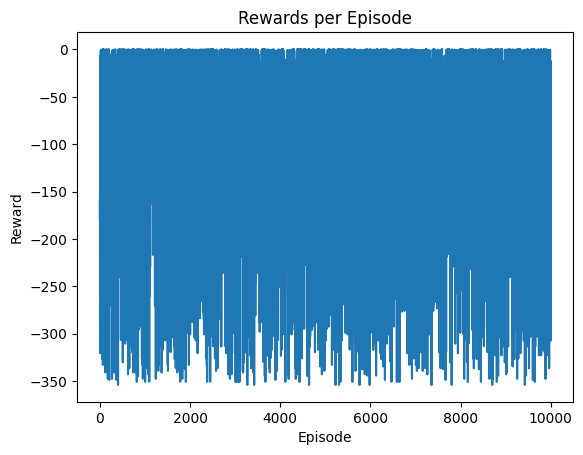

In [5580]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("large_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [5581]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="large_state_to_index.npy")
loaded_qtable = load_q_table(file_path="large_q_table.npy")

In [5582]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                open: float, high: float, ema_26: float, ema_12: float, low: float,
                mean_grad_hist: float, close: float, volume: float, sma_25: float,
                long_jcrosk: float, short_kdj: float, sma_compare: int, is_short: int,
            ):
    state = np.array([[open, high, ema_26, ema_12, low, mean_grad_hist, close, volume, sma_25, long_jcrosk, short_kdj, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [5583]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [5584]:
# Predict an entire range
for idx, row in train_data.iterrows():
    state = row[['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'is_short']].values
    action = predict_action(state, q_table, state_to_index, action_mapping)
    train_data.loc[idx, "predicted_action"] = action

In [5585]:
#train_data.tail(15)
len(q_table)

937

In [5586]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       895
do_nothing     22
go_short       20
Name: count, dtype: int64

In [5587]:
m = train_data[((train_data['predicted_action'] == 'go_short') & (train_data['predicted_action'] == 'do_nothing')) & (train_data['reward'] > 0)]
m['is_short'].value_counts()

Series([], Name: count, dtype: int64)

In [5588]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

None
None


In [5589]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/936
Current Predicted Reward: 0.30116983
Current Actual Reward: 0.30116983
Processed state 100/936
Current Predicted Reward: 32.84699644
Current Actual Reward: -37.10566545999997
Processed state 200/936
Current Predicted Reward: 25.448576699999993
Current Actual Reward: -60.797318449999985
Processed state 300/936
Current Predicted Reward: 27.773860919999983
Current Actual Reward: -58.47203422999995
Processed state 400/936
Current Predicted Reward: 25.022075819999976
Current Actual Reward: -97.59018973000002
Processed state 500/936
Current Predicted Reward: 20.16097902999997
Current Actual Reward: -114.66187199000004
Processed state 600/936
Current Predicted Reward: 21.29321292999997
Current Actual Reward: -142.85595034999997
Processed state 700/936
Current Predicted Reward: 21.29321292999997
Current Actual Reward: -188.74141996000003
Processed state 800/936
Current Predicted Reward: 22.31761290999996
Current Actual Reward: -202.88065601000008
Processed state 900/936
C

In [5590]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 56.35%


In [5591]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[506   0   0]
 [  0   0   0]
 [389  20  22]]


In [5592]:
df0['action'].value_counts()

action
go_long       512
do_nothing    425
Name: count, dtype: int64

In [5634]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}')]
    m = m[m['is_short'] == is_short]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    result = {
        'counts': counts.get(is_short),
        'total': total_reward,
        'wins': wins,
        'losses': losses
    }

    return result

In [5636]:
print(action_reward('go_short', 1))

{'counts': 19, 'total': 35.065686830000004, 'wins': 17, 'losses': 2}


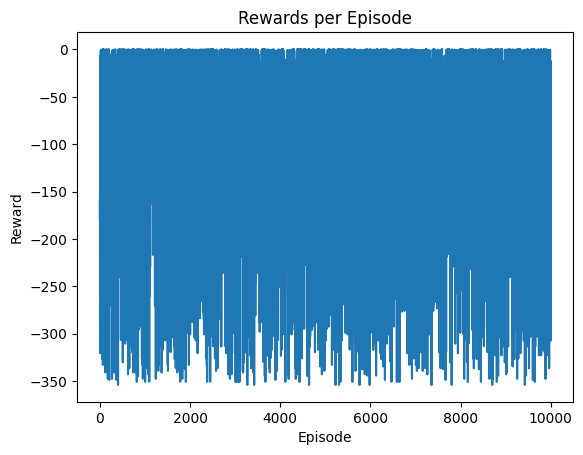

In [5595]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [5596]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [5597]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [5598]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [5599]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [5600]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        